# EDA Series temporales

## Introducción

En este notebook vamos a hacer un pequeño ejercicio exploratorio de una serie temporal. Los datos que vamos a utilizar corresponden a una muestra de datos de la base de datos de Microsoft AdventureWorks2016, extrayendo y exportando los datos en formato csv de SQL SERVER mediante la siguiente query:<br><br>
```
select ShipDate as date, Class as class, sum(SalesAmount) as sales, sum(OrderQuantity) as qty from [AdventureWorksDW2016].[dbo].[FactInternetSales] a
join [AdventureWorksDW2016].[dbo].[DimProduct] b on (a.ProductKey=b.ProductKey)
where Class in ('H','M') group by ShipDate,Class order by 1 asc
```
Los datos corresponden al volumen del histórico de ventas de un negocio online

### Librerías Python  

Importamos librerías

In [1]:
# Importamos librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
import itertools
warnings.filterwarnings("ignore")

## Data Wrangling<a name="datawrangling"></a>

En esta sección vamos a importar los datos, chequear volumen, variables y formatos de cara a poder analizar nuestro dataset.

### Gather data<a name="gather"></a>

Importamos datos con pandas

In [3]:
# importamos dataset
df = pd.read_csv('ts_qty_sales.csv', sep=';')

### Dataframe Properties <a name="properties"></a>

Veamos ahora cómo está estructurado el dataset

In [4]:
# Dimensiones del dataset
print(df.shape)

print('Número de registros: ',df.shape[0])
print('Número de variables: ',df.shape[1])

(1743, 4)
Número de registros:  1743
Número de variables:  4


In [5]:
# Previsualizamos dataset 
df.head()

,date,class,sales,qty
0,2011-01-05 00:00:00.000,H,"13778,24",4
1,2011-01-06 00:00:00.000,H,"13931,52",4
2,2011-01-07 00:00:00.000,H,"14313,08",4
3,2011-01-08 00:00:00.000,H,"7156,54",2
4,2011-01-09 00:00:00.000,H,"14313,08",4


Chequeamos formatos de las 4 variables

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1743 entries, 0 to 1742
Data columns (total 4 columns):
date     1743 non-null object
class    1743 non-null object
sales    1743 non-null object
qty      1743 non-null int64
dtypes: int64(1), object(3)
memory usage: 54.5+ KB


Las fechas tienen formato object con precisión hasta milisegundo, y las ventas aparecen como objeto:

- Transformamos `df.date` a fecha con formato YYYY/MM/DD. Los datos están agrupados por días y no es necesario tener el timestamp completo
- Convertimos a numérico `df.sales` y sustituimos `,` por `.` en el separador de decimales

In [7]:
#formateamos fecha
df['date'] = pd.to_datetime(df['date'], format= '%Y/%m/%d' )
#formateamos sales
df['sales'] = pd.to_numeric(df['sales'].str.replace(',','.'))

Revisamos de nuevo el formato del dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1743 entries, 0 to 1742
Data columns (total 4 columns):
date     1743 non-null datetime64[ns]
class    1743 non-null object
sales    1743 non-null float64
qty      1743 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 54.5+ KB


In [9]:
df.head()

,date,class,sales,qty
0,2011-01-05,H,13778.24,4
1,2011-01-06,H,13931.52,4
2,2011-01-07,H,14313.08,4
3,2011-01-08,H,7156.54,2
4,2011-01-09,H,14313.08,4


Seguimos explorando datos; vemos que tenemos fecha, ventas, volumen y clase. Veamos cuántas clases están definidas

In [10]:
df.nunique()

date     1123
class       2
sales    1098
qty        36
dtype: int64

Tenemos dos; veamos ahora qué valores contiene:

In [11]:
df['class'].unique()

array(['H ', 'M '], dtype=object)

Valores 'H ' y 'M '; limpiemos ahora los espacios sobrantes

In [12]:
# Función strip en python (trim)
df['class'] = df['class'].str.strip()

In [13]:
# Revisamos de nuevo
df['class'].unique()

array(['H', 'M'], dtype=object)

## Data Analysis

Ya hemos refinado nuestro dataset. Analicemos ahora nuestros datos totales y por clases

In [14]:
#dataset agregado por fecha
df_total = df.groupby('date').agg({'sales': 'sum', 'qty': 'sum'})

In [15]:
df_total.head()

,sales,qty
date,,
2011-01-05,13778.24,4
2011-01-06,13931.52,4
2011-01-07,14313.08,4
2011-01-08,7156.54,2
2011-01-09,14313.08,4


### **Análisis agregado**

In [16]:
df_total.describe()

,sales,qty
count,1123.000000,1123.000000
mean,23475.645857,14.454141
std,14993.075686,13.292151
min,87.580000,1.000000
25%,13082.873150,5.000000
50%,19796.535500,8.000000
75%,31554.650250,24.000000
max,87483.810000,70.000000


Veamos cómo se distribuyen los valores a través de un boxplot

Text(0, 0.5, 'Qty Sales')

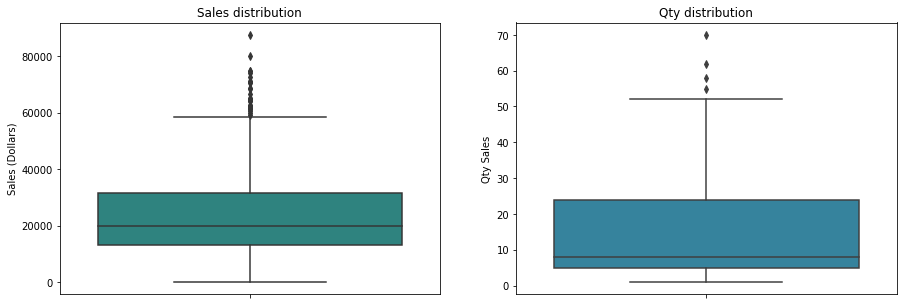

In [17]:
plt.figure(figsize = [15, 5]) 
# histogram on left, example of too-large bin size
plt.subplot(1, 2, 1) # 1 row, 3 cols, subplot 1
ax = sns.boxplot( y=df_total["sales"], palette="viridis")
ax.set_title('Sales distribution')
ax.set_ylabel('Sales (Dollars)')


plt.subplot(1, 2, 2) # 1 row, 2 cols, subplot 2
ax = sns.boxplot( y=df_total["qty"], palette="PuBuGn_d")
ax.set_title('Qty distribution')
ax.set_ylabel('Qty Sales')


Veamos cómo se comportan los datos como serie temporal

In [18]:
ts_total = df_total 

<Figure size 1080x576 with 0 Axes>

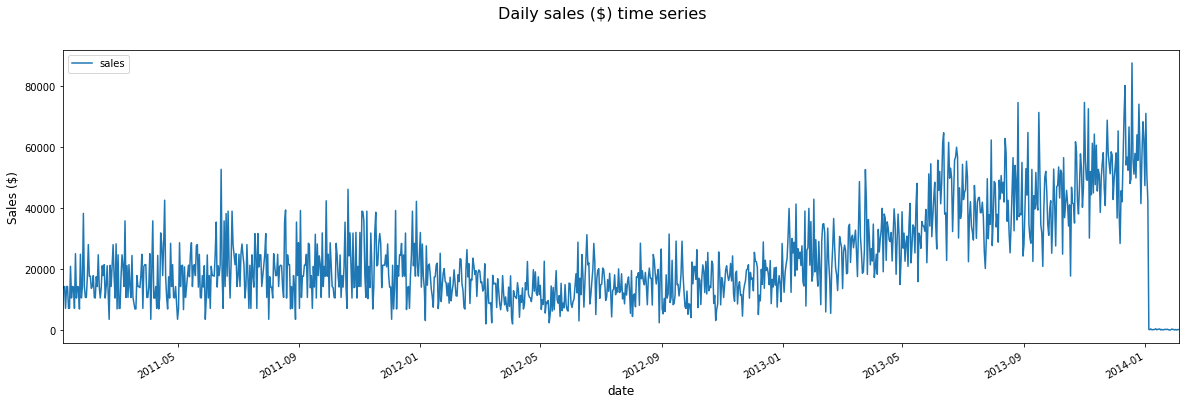

In [19]:
plt.figure(figsize=(15,8))
ts_total.plot(kind='line',  y='sales', label='sales', figsize = (20,6))
plt.suptitle('Daily sales ($) time series', size=16)
plt.ylabel('Sales ($)', size=12)
plt.xlabel('date', size=12)
plt.show()

<Figure size 1080x576 with 0 Axes>

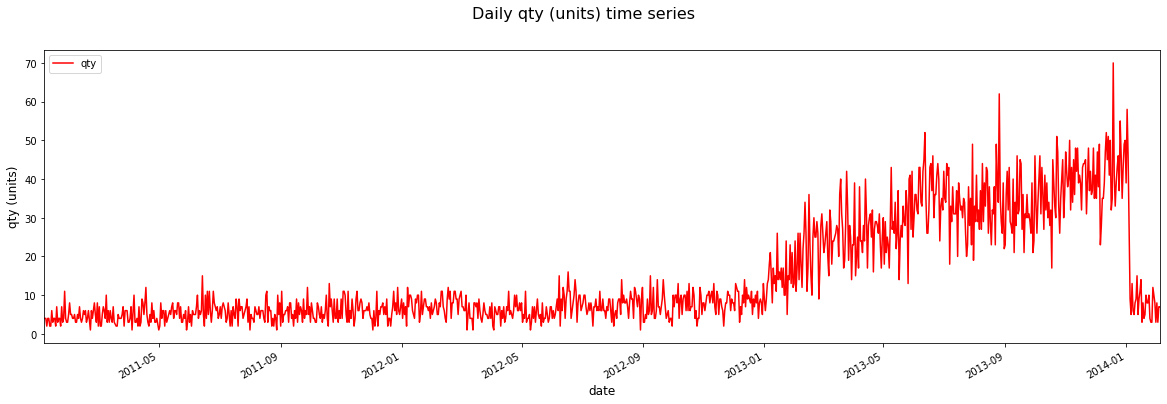

In [20]:
plt.figure(figsize=(15,8))
ts_total.plot(kind='line',  y='qty', label='qty', color= 'red', figsize = (20,6))
plt.suptitle('Daily qty (units) time series', size=16)
plt.ylabel('qty (units)', size=12)
plt.xlabel('date', size=12)
plt.show()

### **Análisis por clase**

In [21]:
df.groupby("class")[['sales','qty']].describe()

sales                                                           \
        count          mean           std    min         25%       50%   
class                                                                    
H      1123.0  19893.670373  11124.975642  32.60  11836.7500  17891.35   
M       620.0   6487.997528   5991.938397  29.99   1000.4375   4597.14   

                               qty                                           \
             75%       max   count      mean       std  min  25%  50%   75%   
class                                                                         
H      26124.330  64129.57  1123.0  9.715939  7.103537  1.0  4.0  7.0  13.0   
M      10369.505  45409.87   620.0  8.582258  7.257196  1.0  2.0  7.0  14.0   

             
        max  
class        
H      39.0  
M      43.0

Veamos cómo se distribuyen los valores por clase a través de un boxplot

Text(0, 0.5, 'Qty Sales')

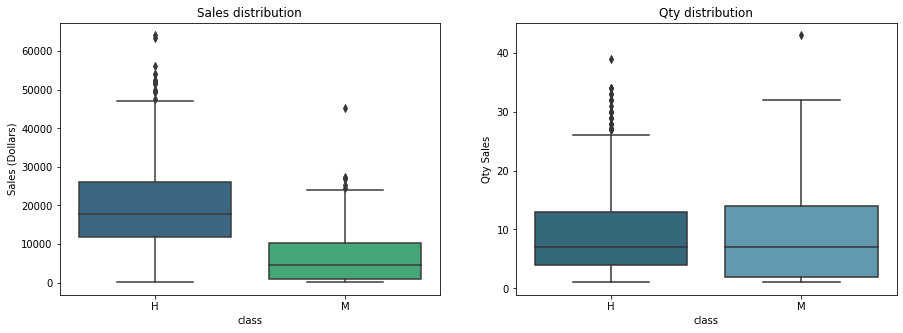

In [22]:
plt.figure(figsize = [15, 5]) 
# histogram on left, example of too-large bin size
plt.subplot(1, 2, 1) # 1 row, 3 cols, subplot 1
ax = sns.boxplot( x= df["class"], y=df["sales"], palette="viridis")
ax.set_title('Sales distribution')
ax.set_ylabel('Sales (Dollars)')


plt.subplot(1, 2, 2) # 1 row, 2 cols, subplot 2
ax = sns.boxplot(x= df["class"], y=df["qty"], palette="PuBuGn_d")
ax.set_title('Qty distribution')
ax.set_ylabel('Qty Sales')


In [23]:
# Asociamos la fecha al índice de la serie temporal ts
df = df.set_index('date')
ts =df

In [24]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1743 entries, 2011-01-05 to 2014-02-04
Data columns (total 3 columns):
class    1743 non-null object
sales    1743 non-null float64
qty      1743 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 54.5+ KB


**Análisis comparativo por clase temporal**

In [25]:
#Separamos dataset en dos partes
ts_H = ts[ts['class'] == "H"]
ts_M = ts[ts['class'] == "M"]

-  **Ventas**

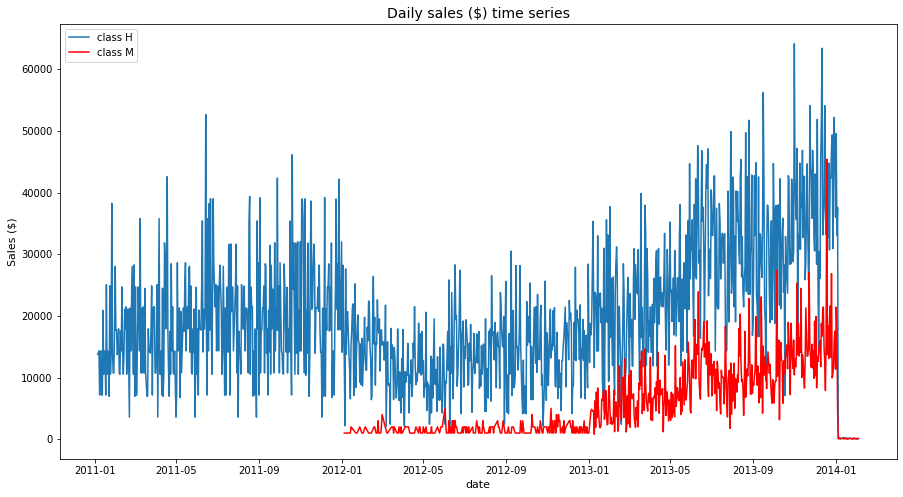

In [26]:
plt.figure(figsize=(15,8))

plt.plot(ts_H.sales, label ='class H')
plt.plot(ts_M.sales, label ='class M', color='red')


plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('date', fontsize = 11)
plt.ylabel('Sales ($)', fontsize = 11)
plt.legend(loc = 'best')
plt.title('Daily sales ($) time series', fontsize = 14)
plt.show()

-  **Unidades**

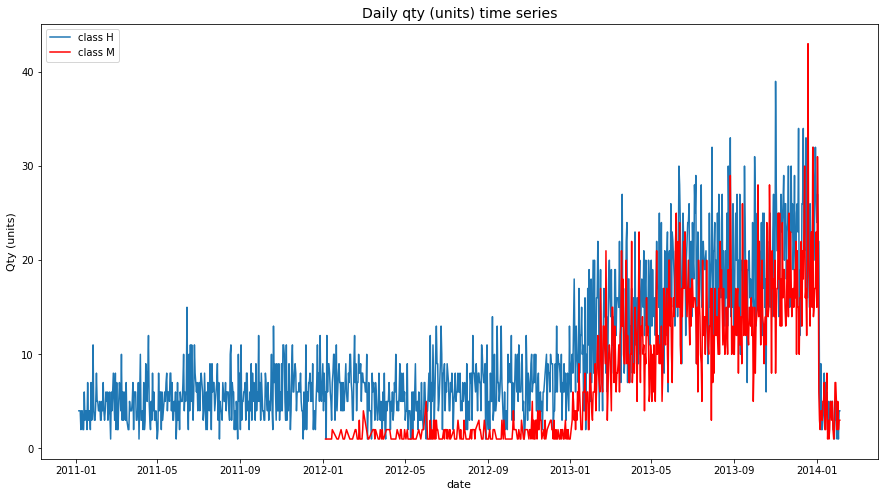

In [27]:
plt.figure(figsize=(15,8))

plt.plot(ts_H.qty, label ='class H')
plt.plot(ts_M.qty, label ='class M', color='red')


plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('date', fontsize = 11)
plt.ylabel('Qty (units)', fontsize = 11)
plt.legend(loc = 'best')
plt.title('Daily qty (units) time series', fontsize = 14)
plt.show()